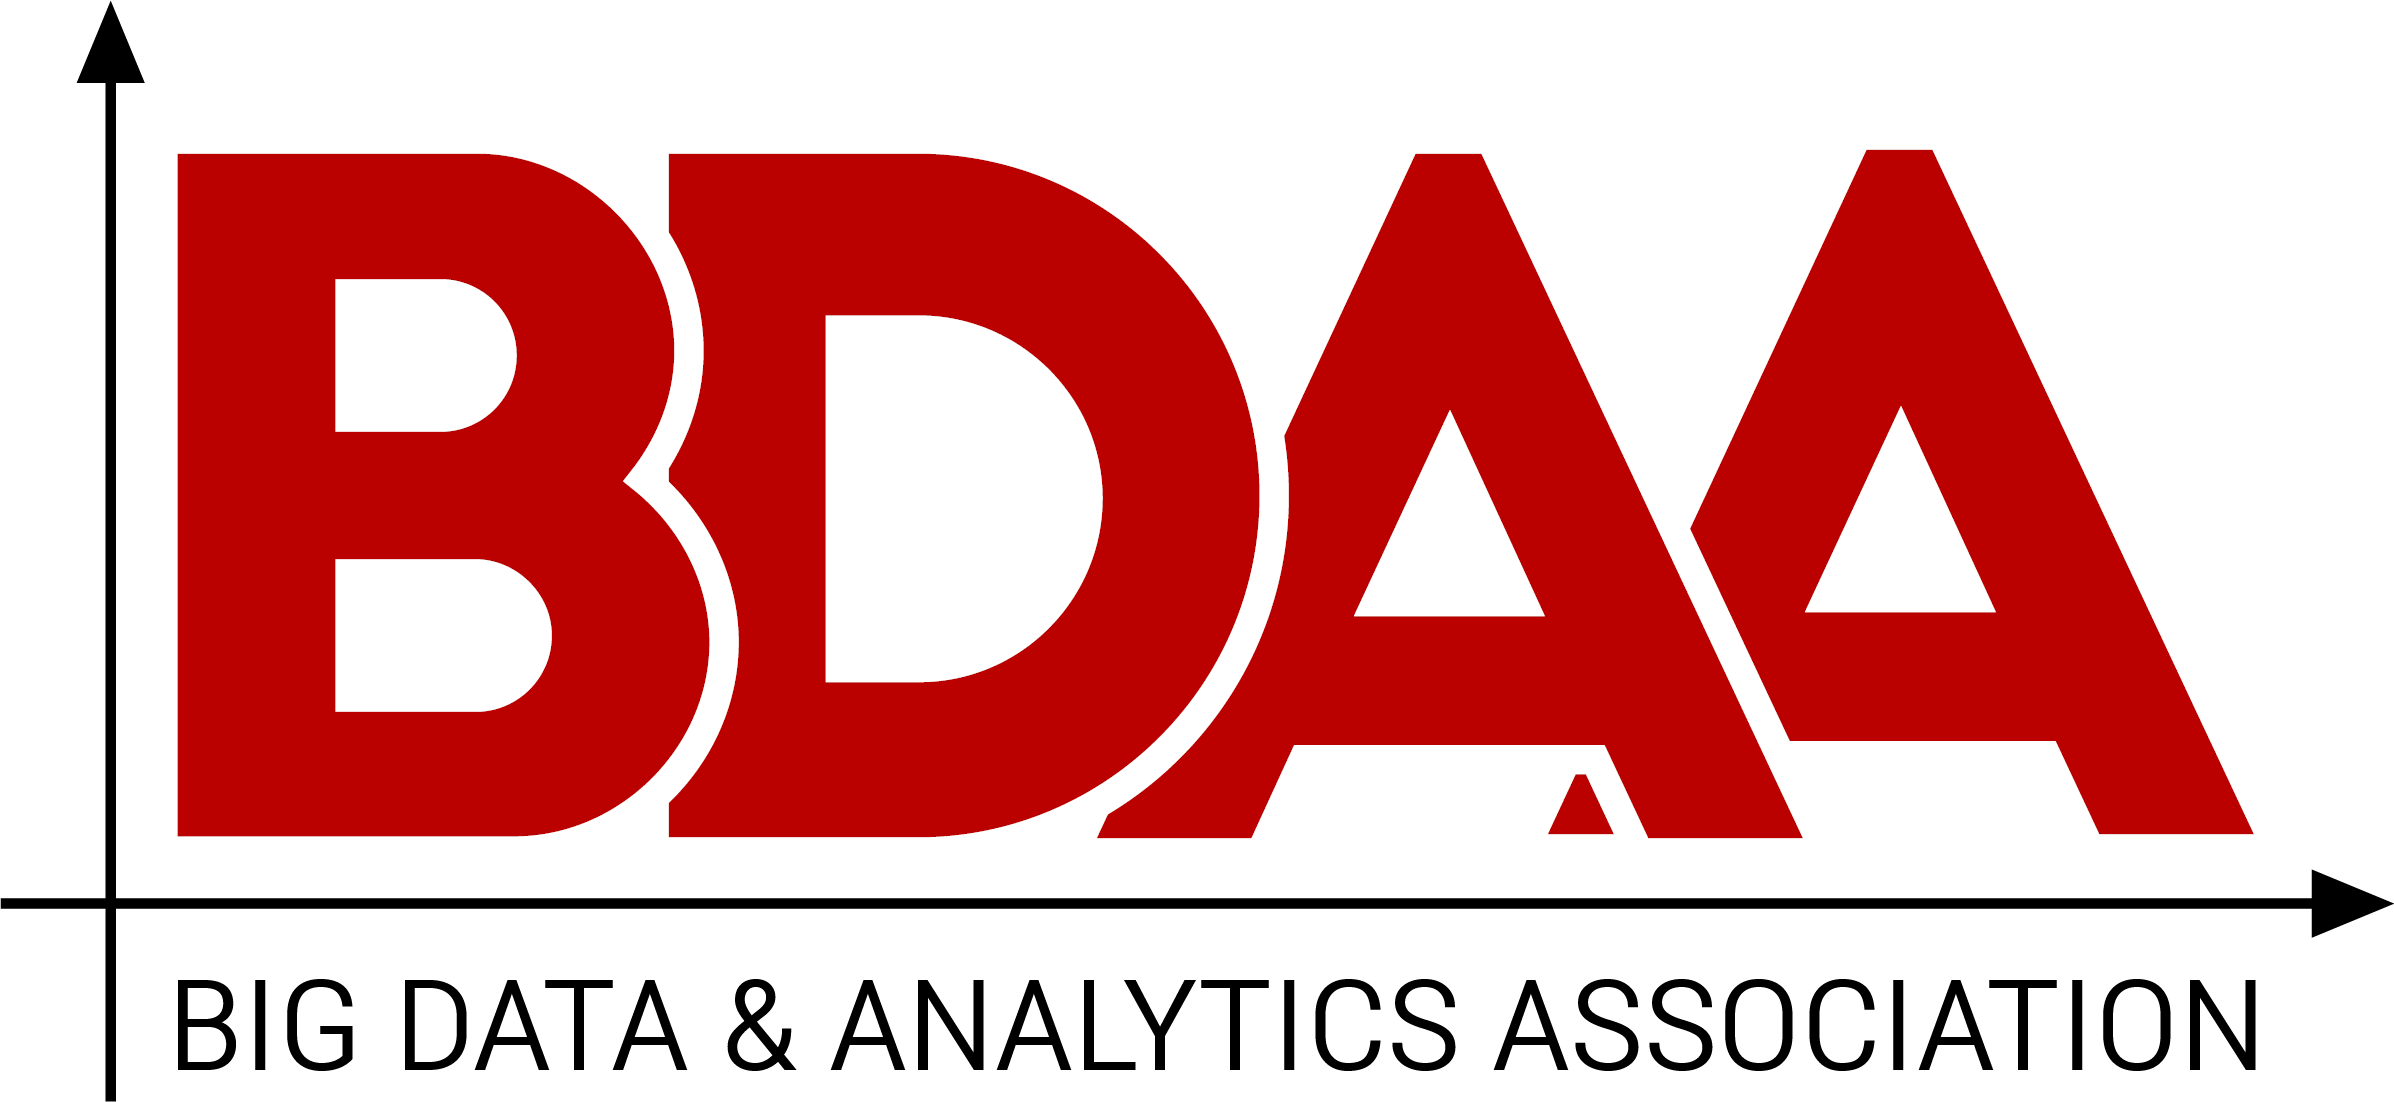

# <center>Intro to Web Scraping - Topic I _Practice_</center>

## Importing and setting up

In [ ]:
# Import all needed modules
import requests # requests.get allows us to connect to a website through Python
from bs4 import BeautifulSoup # BeautifulSoup allows us to parse HTML from requests.get
import pandas as pd # Pandas is a general data management module
import re # String cleanup
import matplotlib.pyplot as plt # For quick data visualizations

In [ ]:
# Open the link
r = requests.get('https://www.tripadvisor.com/RestaurantSearch-g50226-Columbus_Ohio.html')
print(r)

# Read the 'bytes' with BeautifulSoup's html parser and keep it as a bs4 object
soup = BeautifulSoup(r.content, 'html.parser')

***

## Getting into the muck: drilling down into elements

We may be tempted to grab the data we want by referencing generic elements like 'span' that we see in SelectorGadget, but this will likely lead to messy results that will be hard to sift through. Instead, let's componentize our process so that it's easier to drill down into the information that we want.

*Think about what the dataframe should look like!*

After all, every row in our dataframe will represent a restaurant, and every column will represent information about that restaurant.

In [ ]:
# Split the html data by restaurant, which in Tripadvisor is identified by '.shortSellDetails'
restaurants = soup.select('.shortSellDetails')
first_restaurant = restaurants[0]

So what kind of information is available to us?

The following are potential data points available about each restaurant:
 - Name
 - Star rating
 - Number of reviews
 - Derived price range
 - Restaurant type(s)
 - Image?

Looks like plenty of information to base our studies from. Let's start drilling down into each data point!

### Name

Looks like the name is contained in a <_span_> element, which is nested in an <_a_> element. This makes sense, because the name of the element is usually the 'hotlink' to get to that restaurant's Yelp page.

In [ ]:
# Initialize an empty dictionary that will hold the first restaurant's information
restaurant_info = dict()
# Drill, drill, drill! Sort through the mess of <a>s by specifying a unique class.
restaurant_info['name'] = first_restaurant.select('.property_title')[0].text.strip()

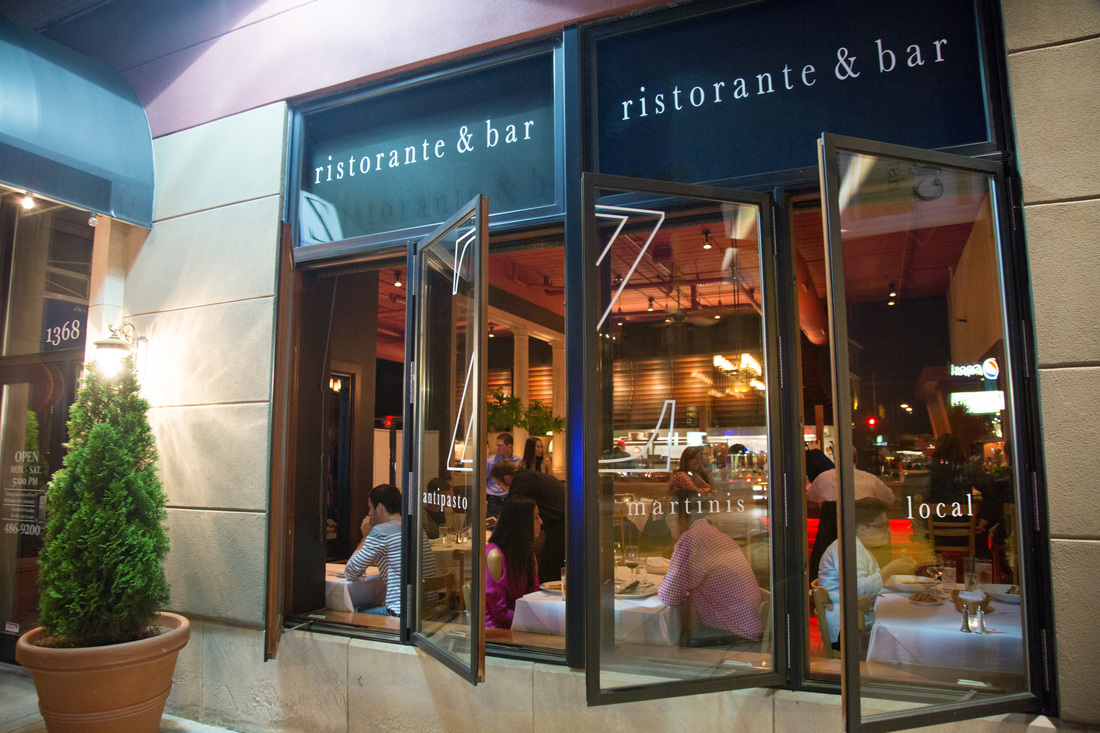

### Number of reviews

In [ ]:
# Use select again!
restaurant_info['num_reviews'] = first_restaurant.select('.rebrand')[0].text.strip()
# Convert that string to an int!
restaurant_info['num_reviews'] = int(restaurant_info['num_reviews'].replace(' reviews', ''))
print(restaurant_info['num_reviews'])

### Derived price range

In [ ]:
# And again..
restaurant_info['price_range'] = first_restaurant.select('.price')[0].text.split(' - ')[-1]
print(restaurant_info['price_range'])

We wont be removing anything from this string, but instead converting the dollar signs ($) to a (discrete) integer, representing the price range rating. Let's count the number of dollar signs in the string and use that instead.

In [ ]:
restaurant_info['price_range'] = restaurant_info['price_range'].count('$')
print(restaurant_info['price_range'])

### Restaurant type(s)

In [ ]:
restaurant_info['type'] = first_restaurant.select('.cuisine')[0].text
print(restaurant_info['type'])

### Image?

Getting the image here is completely optional.. but it may be interesting to do some image classification research here! There are plenty of ways to access/download this image to store.

In [ ]:
restaurant_info['photo'] = soup.select('.photo_image')[0]['src']
print(restaurant_info['photo'])

### Putting it all together

In [ ]:
for cat, value in restaurant_info.items():
    print(cat,":",value)

Congratulations, you just scraped a bunch of information about Hot Chicken Takeover! One data point is never good to base any decisions off of though, so next we will focus on 'operationalizing' what we've done here so that we can start building a database of restaurants on the search results page.

***

## Operationalizing our code

What should our proto-database (pre-pandas) look like? A list of lists is probably the best option here. We'll loop through results, gathering information about each restaurant that we've written the code for, and append the information to a list of lists.

In [ ]:
# Initialize our dataframe to return
restaurants_db = pd.DataFrame()
    
# Remember that we've only been using the first element of the restaurants object that we created before, 
# so we will be looping through that object to get our information.
for i in range(len(restaurants)):
    restaurant = restaurants[i]
    
    restaurant_info = dict()
    # NAME
    restaurant_info['name'] = restaurant.select('.property_title')[0].text.strip()
    
    # NUM REVIEWS
    restaurant_info['num_reviews'] = restaurant.select('.rebrand')[0].text.strip()
    restaurant_info['num_reviews'] = int(re.sub(',| reviews', '', restaurant_info['num_reviews']))
    
    # PRICE RANGE
    restaurant_info['price_range'] = restaurant.select('.price')[0].text.split(' - ')[-1]
    restaurant_info['price_range'] = restaurant_info['price_range'].count('$')
    
    # RESTAURANT TYPE
    restaurant_info['type'] = restaurant.select('.cuisine')[0].text
        
    # PHOTO
    restaurant_info['image'] = soup.select('.photo_image')[i]['src']
    
    # Building the proto-database
    restaurants_db = restaurants_db.append(restaurant_info, ignore_index=True)

print(restaurants_db)

Let's make a function out of all of our code, just in case we may need to reuse it in the future ;)

In [ ]:
def parse_restaurants(link):
    # Open the link
    r = requests.get(link)
    soup = BeautifulSoup(r.content, 'html.parser')

    restaurants = soup.select('.shortSellDetails')

    # Initialize our dataframe to return
    restaurants_db = pd.DataFrame()
    
    # Remember that we've only been using the first element of the restaurants object that we created before, 
    # so we will be looping through that object to get our information.
    for i in range(len(restaurants)):
        restaurant = restaurants[i]
    
        restaurant_info = dict()
        # NAME
        restaurant_info['name'] = restaurant.select('.property_title')[0].text.strip()
    
        # STAR RATING
        #restaurant_info['star_rating'] = restaurant.select('.rating-large')[0]['title']
        #restaurant_info['star_rating'] = float(re.sub(' star rating', '', restaurant_info['star_rating']))
    
        # NUM REVIEWS
        restaurant_info['num_reviews'] = restaurant.select('.rebrand')[0].text.strip()
        restaurant_info['num_reviews'] = int(restaurant_info['num_reviews'].replace(' reviews', '').replace(',', ''))
    
        # PRICE RANGE
        restaurant_info['price_range'] = restaurant.select('.price')[0].text.split(' - ')[-1]
        restaurant_info['price_range'] = restaurant_info['price_range'].count('$')
    
        # RESTAURANT TYPE
        restaurant_info['type'] = restaurant.select('.cuisine')[0].text
        
        # PHOTO
        restaurant_info['image'] = soup.select('.photo_image')[i]['src']
    
        # Building the proto-database
        restaurants_db = restaurants_db.append(restaurant_info, ignore_index=True)

    return restaurants_db

print(parse_restaurants('https://www.tripadvisor.com/RestaurantSearch-g50226-oa0-Columbus_Ohio.html'))

***

## Getting more data: playing with links

30 restaurants is great to start (and conviniently meets the 'sufficiently large' requirement for the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)), but in this case, more data is better. Yelp returned ~4600 results from our basic search, but let's focus on the top 180 restaurants that are returned.

As we've seen, we can iterate through Yelp's search results by simply changing the suffix of the results link. If we want 180 results, we will have to do this 6 times, which means a for loop!

In [ ]:
# Initialize an empty dataframe
restaurants_db = pd.DataFrame()
for i in range(4):
    print(i)
    # Append the starting restaurant index to the base link
    link = 'https://www.tripadvisor.com/RestaurantSearch-g50226-oa' + str(i*30) + '-Columbus_Ohio.html'
    temp_db = parse_restaurants(link)
    
    restaurants_db = restaurants_db.append(temp_db)
print(restaurants_db)

## The fruit of our labor: Some quick visualizations

In [ ]:
# Get the frequency for each neighborhood and plot it, all in one line!
restaurants_db['price_range'].value_counts().plot.bar()
plt.title('Price Range Distribution - Columbus')
fig=plt.gcf()
fig.set_size_inches(8,8)
plt.show()

In [ ]:
# Plot!
restaurants_db['type'].value_counts(ascending=True).plot.barh(width=1.0)
plt.title('Top Restaurant Types - Columbus')
fig=plt.gcf()
fig.set_size_inches(8,20)
plt.show()

In [ ]:
# Wrangle all single types in the 'type' column into a list
#types = []
#for _type in restaurants_db['type']:
#    types.append(_type.split(',  '))
#types = [_type for type_list in types for _type in type_list]

# Convert this list to a dictionary, with keys being types and values being the counts of each type
#counts = {_type:types.count(_type) for _type in types}
# Convert this dictionary to a dataframe
#counts = pd.DataFrame(list(counts.items()), columns=['Type', 'Count'])
# And sort it by value for pretty plotting
#counts.sort_values(by=['Count'], inplace=True)

#counts.plot(x='type',y='Count',kind='barh')